# Ray RLlib Multi-Armed Bandits - Market Bandit Example

© 2019-2021, Anyscale. All Rights Reserved

![Anyscale Academy](../../images/AnyscaleAcademyLogo.png)

Now that we've learned about multi-armed bandits and methods for optimizing rewards, let's look at real-world applications, starting with a stock market example.

How well could you invest in the public markets, if you could only observe one macroeconomic signal *inflation* and could only update your investments once each year?

To explore this, first we'll load a dataset derived from this [NYU Stern table](http://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/histretSP.html) that shows returns for nearly a century of market data, including dividends and adjustments for inflation. The `market.tsv` file in this folder contains the data.

In [1]:
import pandas as pd
import numpy as np
import os
import sys

In [2]:
# Some properties we'll need:
DEFAULT_MAX_INFLATION = 100.0
DEFAULT_TICKERS = ["sp500", "t.bill", "t.bond", "corp"]
DEFAULT_DATA_FILE = os.path.abspath(os.path.curdir) + "/market.tsv"  # full path

In [3]:
def load_market_data (file_name):
    with open(file_name, "r") as f:
        return pd.read_table(f)

Let's load and examine the data:

In [4]:
df = load_market_data(DEFAULT_DATA_FILE)
df

,year,inflation,sp500,t.bill,t.bond,corp
0,1928,-1.15,45.49,4.28,2.01,4.42
1,1929,0.00,-8.30,3.16,4.20,3.02
2,1930,-2.67,-23.07,7.42,7.41,3.30
3,1931,-8.93,-38.33,12.34,7.00,-7.41
4,1932,-10.30,1.85,12.68,21.28,37.78
...,...,...,...,...,...,...
87,2015,0.12,1.26,-0.07,1.16,-0.82
88,2016,1.26,10.38,-0.93,-0.56,8.99
89,2017,2.13,19.07,-1.17,0.66,7.44
90,2018,2.44,-6.51,-0.49,-2.40,-5.08


As you can see the data spans 92 years, from 1928 to 2019. 

The columns represent:
  * `year`: the year
  * `inflation`: the inflation rate at the time
  * `sp500`: [S&P500](https://en.wikipedia.org/wiki/S%26P_500_Index) (composite stock index)
  * `t.bill`: [Treasury Bills](https://www.investopedia.com/terms/t/treasurybill.asp) (short-term gov bonds)
  * `t.bond`: [Treasury Bonds](https://www.investopedia.com/terms/t/treasurybond.asp) (long-term gov bonds)
  * `corp`: [Moody's Baa Corporate Bonds](https://en.wikipedia.org/wiki/Moody%27s_Investors_Service#Moody's_credit_ratings) (moderate risk)

## Analysis of the Data

Let's also look at descriptions statistics for each column:

In [5]:
df.describe()

,year,inflation,sp500,t.bill,t.bond,corp
count,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1973.50000,3.041957,8.413261,0.434239,2.166413,4.216630
std,26.70206,3.803579,19.619605,3.573035,8.126432,8.625809
min,1928.00000,-10.300000,-38.900000,-12.050000,-14.570000,-14.850000
25%,1950.75000,1.415000,-2.740000,-1.185000,-2.620000,-1.322500
50%,1973.50000,2.750000,10.515000,0.590000,1.070000,3.910000
75%,1996.25000,4.275000,20.622500,2.117500,7.037500,9.287500
max,2019.00000,14.390000,58.200000,12.680000,25.140000,37.780000


What are the worst case and best case scenarios? In other words, if one could predict the future market performance, what are the possible ranges of total failure vs. total success over the past century? By "total", we mean what if you had all your money in a given year invested in the worst performing _sector_ (S&P500, T bills, or other) or you were invested in the best performing sector for that year.

In [6]:
n_years = len(df)
min_list = []
max_list = []

for i in range(n_years):
    row = df.iloc[i, 2:]
    min_list.append(min(row))
    max_list.append(max(row))
    
print("{:5.2f}% worst case annualized".format(sum(min_list) / n_years))
print("{:5.2f}% best case annualized".format(sum(max_list) / n_years))

-5.64% worst case annualized
15.18% best case annualized


In [7]:
min_max = pd.DataFrame.from_dict({'year': df['year'], 'min':min_list, 'max':max_list})
min_max

,year,min,max
0,1928,2.01,45.49
1,1929,-8.30,4.20
2,1930,-23.07,7.42
3,1931,-38.33,12.34
4,1932,1.85,37.78
...,...,...,...
87,2015,-0.82,1.26
88,2016,-0.93,10.38
89,2017,-1.17,19.07
90,2018,-6.51,-0.49


We can visualize the best and worst returns, year over year.
Overall this should look like a [*random walk*](https://en.wikipedia.org/wiki/Random_walk):

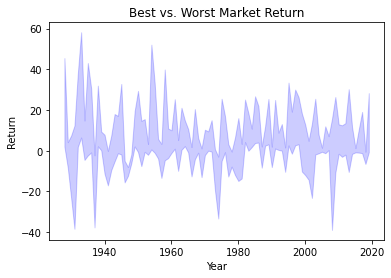

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.fill_between(
    df["year"],
    min_list,
    max_list,
    color="b",
    alpha=0.2
)

plt.title("Best vs. Worst Market Return")
plt.xlabel("Year")
plt.ylabel("Return")
plt.show()

There are some years where the performance varies widely, while other years everything returns about the same performance.

## Defining an Environment

Now let's define a Gym environment so that we can train a contextual bandit to optimize annual investments over that period.

In [9]:
import gym
from gym.spaces import Discrete, Box
from gym.utils import seeding
import random

This is the bandit we'll use to represent the market "environment".

In [10]:
class MarketBandit (gym.Env):
    
    def __init__ (self, config={}):
        self.max_inflation = config.get("max-inflation", DEFAULT_MAX_INFLATION)
        self.tickers = config.get("tickers", DEFAULT_TICKERS)
        self.data_file = config.get("data-file", DEFAULT_DATA_FILE)
        print(f"MarketBandit: max_inflation: {self.max_inflation}, tickers: {self.tickers}, data file: {self.data_file} (config: {config})")

        self.action_space = Discrete(4)
        self.observation_space = Box(
            low  = -self.max_inflation,
            high =  self.max_inflation,
            shape=(1, )
        )
        self.df = load_market_data(self.data_file)
        self.cur_context = None


    def reset (self):
        self.year = self.df["year"].min()
        self.cur_context = self.df.loc[self.df["year"] == self.year]["inflation"][0]
        self.done = False
        self.info = {}

        return [self.cur_context]


    def step (self, action):
        if self.done:
            reward = 0.
            regret = 0.
        else:
            row = self.df.loc[self.df["year"] == self.year]

            # calculate reward
            ticker = self.tickers[action]
            reward = float(row[ticker])

            # calculate regret
            max_reward = max(map(lambda t: float(row[t]), self.tickers))
            regret = round(max_reward - reward)

            # update the context
            self.cur_context = float(row["inflation"])

            # increment the year
            self.year += 1

            if self.year >= self.df["year"].max():
                self.done = True

        context = [self.cur_context]
        #context = self.observation_space.sample()

        self.info = {
            "regret": regret,
            "year": self.year
        }
         
        return [context, reward, self.done, self.info]


    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's random
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

Let's see it in action:

In [11]:
bandit = MarketBandit()
bandit.reset()

for i in range(10):
    action = bandit.action_space.sample()
    obs = bandit.step(action)
    print(action, obs)

MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/ceteri/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
0 [[-1.15], 45.49, False, {'regret': 0, 'year': 1929}]
2 [[0.0], 4.2, False, {'regret': 0, 'year': 1930}]
0 [[-2.67], -23.07, False, {'regret': 30, 'year': 1931}]
3 [[-8.93], -7.41, False, {'regret': 20, 'year': 1932}]
1 [[-10.3], 12.68, False, {'regret': 25, 'year': 1933}]
1 [[-5.19], 6.49, False, {'regret': 52, 'year': 1934}]
0 [[3.48], -4.51, False, {'regret': 19, 'year': 1935}]
1 [[2.55], -2.33, False, {'regret': 45, 'year': 1936}]
1 [[1.03], -0.85, False, {'regret': 31, 'year': 1937}]
1 [[3.73], -3.33, False, {'regret': 1, 'year': 1938}]


We can use this environment in a kind of [*monte carlo simulation*](https://en.wikipedia.org/wiki/Monte_Carlo_method) to measure a baseline for what the rewards would be over a long period if you merely used actions selected at random.

In [12]:
done = 1
reward_list = []
iterations = 10000 #50000

for i in range(iterations):
    if done == 1:
        bandit.reset()

    action = bandit.action_space.sample()
    obs = bandit.step(action)
    context, reward, done, info = obs
    reward_list.append(reward)
    #print(action, context, reward, done, info)

In [13]:
df_mc = pd.DataFrame(reward_list, columns=["reward"])
df_mc.mean()

reward    3.8159
dtype: float64

Depending on the number of iterations, you'll probably get a value approaching 3.75% as a baseline for random actions. That's more than the -5.64% worst case and must less than 15.18% best case for the reward!

<AxesSubplot:title={'center':'Reward Over Iterations'}>

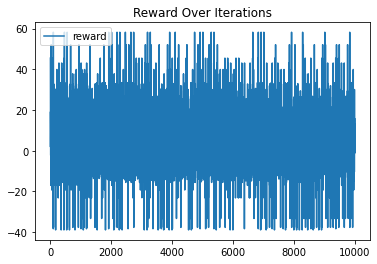

In [14]:
df_mc.plot(y="reward", title="Reward Over Iterations")

([image](../../images/rllib/MarketReward-Random.png))

Yes, it looks quite random... There is no improvement (i.e., *learning*) happening at all.

## Training a policy in RLlib

Now let's train a policy using our contextual bandit, specifically using _Linear Thompson Sampling_ in RLlib. Hopefully it will do better than the random results we just computed!

Recall in the `__init__()` method for `MarketBandit` that we set some parameters from the passed in `config` object. 
So we need to create a custom config object with our parameters, by building on the default `TS_CONFIG` object for _LinTS_:

In [15]:
import copy
from ray.rllib.contrib.bandits.agents.lin_ts import TS_CONFIG

market_config = copy.deepcopy(TS_CONFIG)

market_config["env"] = MarketBandit
market_config["max-inflation"] = DEFAULT_MAX_INFLATION;
market_config["tickers"] = DEFAULT_TICKERS;
market_config["data-file"] = DEFAULT_DATA_FILE;

Instructions for updating:
non-resource variables are not supported in the long term


We'll also define a custom trainer, which builds on the `LinTSTrainer` with "updates". 
This will be the first argument that we'll pass to `ray.tune.run()` later. 

Note: if all we needed was the default `LinTSTrainer` trainer, as is and with no customized config settings, we could instead just pass the string `"contrib/LinTS"` to `ray.tune.run()`.  

In [16]:
from ray.rllib.contrib.bandits.agents.lin_ts import LinTSTrainer

MarketLinTSTrainer = LinTSTrainer.with_updates(
    name="MarketLinTSTrainer",
    default_config=market_config,      # Will be merged with Trainer.COMMON_CONFIG (rllib/agent/trainer.py)
    #default_policy=[somePolicyClass]  # If we had a policy...
)

Then initialize Ray:

In [17]:
import ray

ray.init(ignore_reinit_error=True, num_cpus=2)

2021-05-22 22:54:38,393	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.138.0.19',
 'raylet_ip_address': '10.138.0.19',
 'redis_address': '10.138.0.19:6379',
 'object_store_address': '/tmp/ray/session_2021-05-22_22-54-37_773248_1078/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-22_22-54-37_773248_1078/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-22_22-54-37_773248_1078',
 'metrics_export_port': 49394,
 'node_id': 'ab780975deb9f87444ed163161d4e4646bd7414984c820f1283c5f89'}

Then run Tune:

In [19]:
stop = {
    "training_iteration": 100
}

analysis = ray.tune.run(
    MarketLinTSTrainer,
    config=market_config,
    stop=stop,
    num_samples=3,
)

Trial name,status,loc
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,


(pid=1249) WARNING:tensorflow:From /home/ceteri/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1249) Instructions for updating:
(pid=1249) non-resource variables are not supported in the long term
(pid=1286) WARNING:tensorflow:From /home/ceteri/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1286) Instructions for updating:
(pid=1286) non-resource variables are not supported in the long term
(pid=1249) 2021-05-22 22:56:34,160	INFO trainer.py:641 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=1249) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/ceteri/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})


(pid=1249) 2021-05-22 22:56:34,360	WARNING util.py:47 -- Install gputil for GPU system monitoring.
(pid=1249) 2021-05-22 22:56:34,384	WARNING deprecation.py:33 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!
(pid=1286) 2021-05-22 22:56:34,660	INFO trainer.py:641 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=1286) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/ceteri/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
Result for MarketLinTSTrainer_MarketBandit_f2785_00000:
  custom_metrics: {}
  date: 2021-05-22_22-56-34
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 666.71
  episode_reward_mean: 666.71
  episode_reward_min: 666.71
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 15f6a7b8453846208a060ee8a750551f
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 832
        update_latency: 0.00028061866760253906
    num_steps_sampled: 100
    num_steps_trained: 100
  iterations_since_restore: 1
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.1
    ram_util_percent: 37.3
  pid: 1249
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_m

(pid=1286) 2021-05-22 22:56:34,866	WARNING util.py:47 -- Install gputil for GPU system monitoring.
(pid=1286) 2021-05-22 22:56:34,873	WARNING deprecation.py:33 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-56-35
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 649.4599999999999
  episode_reward_mean: 649.4599999999999
  episode_reward_min: 649.4599999999999
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 890
        update_latency: 0.00030684471130371094
    num_steps_sampled: 100
    num_steps_trained: 100
  iterations_since_restore: 1
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 99.0
    ram_util_percent: 37.5
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.09899800366694385
    mean_env_wait_ms: 1.6063109482869062
    mean_inference_ms: 1.0832536338579537
    mean_raw_obs_processing_ms: 0.56215087966163

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,3,1.17922,300,654.787,781.21,516.44,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,1,0.411829,100,649.46,649.46,649.46,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00000:
  custom_metrics: {}
  date: 2021-05-22_22-56-40
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 781.21
  episode_reward_mean: 644.704
  episode_reward_min: 516.4399999999999
  episodes_this_iter: 1
  episodes_total: 15
  experiment_id: 15f6a7b8453846208a060ee8a750551f
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 11177
        update_latency: 0.0003323554992675781
    num_steps_sampled: 1400
    num_steps_trained: 1400
  iterations_since_restore: 14
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 98.6
    ram_util_percent: 37.5
  pid: 1249
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.0664438327514121
    mean_env_wait_ms: 1.5808854091391162
    mean_inference_ms: 1.0976012446774406
    mean_raw_obs_processing_ms: 0.4783290673143364
  time_since_r

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,15,5.80241,1500,643.309,781.21,516.44,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,14,5.51256,1400,561.877,674.04,455.25,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00000:
  custom_metrics: {}
  date: 2021-05-22_22-56-45
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 781.21
  episode_reward_mean: 602.1606896551725
  episode_reward_min: 480.10000000000014
  episodes_this_iter: 1
  episodes_total: 29
  experiment_id: 15f6a7b8453846208a060ee8a750551f
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 22850
        update_latency: 0.0003657341003417969
    num_steps_sampled: 2700
    num_steps_trained: 2700
  iterations_since_restore: 27
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 98.6
    ram_util_percent: 37.5
  pid: 1249
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.06564048074137763
    mean_env_wait_ms: 1.5598884587473874
    mean_inference_ms: 1.093379567897896
    mean_raw_obs_processing_ms: 0.4697913507745659
  t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,28,10.8049,2800,597.766,781.21,470.31,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,27,10.5659,2700,573.833,674.04,455.25,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00000:
  custom_metrics: {}
  date: 2021-05-22_22-56-50
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 781.21
  episode_reward_mean: 585.4732558139535
  episode_reward_min: 417.4500000000001
  episodes_this_iter: 1
  episodes_total: 43
  experiment_id: 15f6a7b8453846208a060ee8a750551f
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 34315
        update_latency: 0.0003447532653808594
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 40
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1249
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.06514889211528978
    mean_env_wait_ms: 1.5487079800212817
    mean_inference_ms: 1.0940796434538453
    mean_raw_obs_processing_ms: 0.46601348475021764
  time_since_restore: 15.48161005973816
  time_this_i

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,41,15.8568,4100,584.719,781.21,417.45,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,39,15.2709,3900,589.639,784.07,455.25,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-56-51
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 784.0699999999997
  episode_reward_mean: 591.6832558139536
  episode_reward_min: 455.24999999999994
  episodes_this_iter: 1
  episodes_total: 43
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 34059
        update_latency: 0.0003783702850341797
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 40
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 97.9
    ram_util_percent: 37.5
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.07257931663091276
    mean_env_wait_ms: 1.58984216347488
    mean_inference_ms: 1.0996336984756527
    mean_raw_obs_processing_ms: 0.4833890641

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,53,20.7325,5300,582.458,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,51,20.0079,5100,595.636,784.07,455.25,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-56-56
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 784.0699999999997
  episode_reward_mean: 596.3406896551725
  episode_reward_min: 455.24999999999994
  episodes_this_iter: 1
  episodes_total: 58
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 44963
        update_latency: 0.00040340423583984375
    num_steps_sampled: 5300
    num_steps_trained: 5300
  iterations_since_restore: 53
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.07129756594102066
    mean_env_wait_ms: 1.5813207867462784
    mean_inference_ms: 1.099790639882194
    mean_raw_obs_processing_ms: 0.4795061116110381
  time_since_restore: 20.801920413970947
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,65,25.3248,6500,588.538,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,64,25.1356,6400,589.017,784.07,448.01,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-57-01
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 784.0699999999997
  episode_reward_mean: 585.2094444444444
  episode_reward_min: 427.69000000000017
  episodes_this_iter: 1
  episodes_total: 72
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 56838
        update_latency: 0.0005450248718261719
    num_steps_sampled: 6600
    num_steps_trained: 6600
  iterations_since_restore: 66
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.070451285039514
    mean_env_wait_ms: 1.5754703576679705
    mean_inference_ms: 1.1000747015136776
    mean_raw_obs_processing_ms: 0.4766147186383012
  time_since_restore: 25.97362518310547
  ti

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,78,30.6053,7800,591.436,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,75,29.7131,7500,587.047,784.07,427.69,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-57-07
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 784.0699999999997
  episode_reward_mean: 587.2792941176472
  episode_reward_min: 427.69000000000017
  episodes_this_iter: 1
  episodes_total: 85
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 66802
        update_latency: 0.0004253387451171875
    num_steps_sampled: 7800
    num_steps_trained: 7800
  iterations_since_restore: 78
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.0699184850741088
    mean_env_wait_ms: 1.5726848520562065
    mean_inference_ms: 1.1014710175619395
    mean_raw_obs_processing_ms: 0.4753307370321197
  time_since_restore: 30.894913911819458
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,RUNNING,10.138.0.19:1249,91,35.6485,9100,591.458,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,RUNNING,10.138.0.19:1286,88,34.7743,8800,585.094,784.07,427.69,91
MarketLinTSTrainer_MarketBandit_f2785_00002,PENDING,,,,,,,,


Result for MarketLinTSTrainer_MarketBandit_f2785_00001:
  custom_metrics: {}
  date: 2021-05-22_22-57-12
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 784.0699999999997
  episode_reward_mean: 583.7083000000001
  episode_reward_min: 427.69000000000017
  episodes_this_iter: 2
  episodes_total: 100
  experiment_id: 571671003b5a43c6b6715abf745ae6c6
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 78318
        update_latency: 0.0005376338958740234
    num_steps_sampled: 9100
    num_steps_trained: 9100
  iterations_since_restore: 91
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1286
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.06938905511257785
    mean_env_wait_ms: 1.569044941182094
    mean_inference_ms: 1.1021804110436542
    mean_raw_obs_processing_ms: 0.4742560389632648
  time_since_restore: 36.01441287994385
  

(pid=1309) WARNING:tensorflow:From /home/ceteri/.local/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1309) Instructions for updating:
(pid=1309) non-resource variables are not supported in the long term
(pid=1309) 2021-05-22 22:57:19,076	INFO trainer.py:641 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=1309) 2021-05-22 22:57:19,218	WARNING util.py:47 -- Install gputil for GPU system monitoring.
(pid=1309) 2021-05-22 22:57:19,227	WARNING deprecation.py:33 -- DeprecationWarning: `env_index` has been deprecated. Use `episode.env_id` instead. This will raise an error in the future!


(pid=1309) MarketBandit: max_inflation: 100.0, tickers: ['sp500', 't.bill', 't.bond', 'corp'], data file: /home/ceteri/rllib_tutorials/rl_apps/multi-armed-bandits/market.tsv (config: {})
Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-19
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 642.2899999999998
  episode_reward_mean: 642.2899999999998
  episode_reward_min: 642.2899999999998
  episodes_this_iter: 1
  episodes_total: 1
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 857
        update_latency: 0.00026297569274902344
    num_steps_sampled: 100
    num_steps_trained: 100
  iterations_since_restore: 1
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 69.5
    ram_util_percent: 31.3
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_p

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,1,0.269831,100,642.29,642.29,642.29,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-24
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 820.8299999999998
  episode_reward_mean: 557.6495652173915
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 2
  episodes_total: 23
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 18795
        update_latency: 0.0002110004425048828
    num_steps_sampled: 2100
    num_steps_trained: 2100
  iterations_since_restore: 21
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03970569902501342
    mean_env_wait_ms: 0.946084894829418
    mean_inference_ms: 0.6896370767339698
    mean_raw_obs_processing_ms: 0.28684869552009984
  time_since_restore: 5.04111385345459
  t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,21,5.04111,2100,557.65,820.83,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-29
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 820.8299999999998
  episode_reward_mean: 567.3252631578947
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 38
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 30827
        update_latency: 0.0003018379211425781
    num_steps_sampled: 3500
    num_steps_trained: 3500
  iterations_since_restore: 35
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03954841524819873
    mean_env_wait_ms: 0.9617482330670205
    mean_inference_ms: 0.6969284804099957
    mean_raw_obs_processing_ms: 0.30200688695244443
  time_since_restore: 10.046885251998901


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,35,10.0469,3500,567.325,820.83,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-35
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 575.4151020408164
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 49
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 39192
        update_latency: 0.00024008750915527344
    num_steps_sampled: 4500
    num_steps_trained: 4500
  iterations_since_restore: 45
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03955788605567928
    mean_env_wait_ms: 1.0283227380900226
    mean_inference_ms: 0.7307577944617039
    mean_raw_obs_processing_ms: 0.32504638573298567
  time_since_restore: 15.06908655166626


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,45,15.0691,4500,575.415,843.82,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-40
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 580.7035
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 60
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 47525
        update_latency: 0.0003044605255126953
    num_steps_sampled: 5500
    num_steps_trained: 5500
  iterations_since_restore: 55
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03961638813598865
    mean_env_wait_ms: 1.0744233727397676
    mean_inference_ms: 0.772001585658743
    mean_raw_obs_processing_ms: 0.3528620186593348
  time_since_restore: 19.91361117362976
  time_this_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,55,19.9136,5500,580.703,843.82,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-45
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 581.283661971831
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 71
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 56271
        update_latency: 0.0002841949462890625
    num_steps_sampled: 6500
    num_steps_trained: 6500
  iterations_since_restore: 65
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03965654001211319
    mean_env_wait_ms: 1.1212807099172155
    mean_inference_ms: 0.8126831827573555
    mean_raw_obs_processing_ms: 0.37777465273036953
  time_since_restore: 25.035199403762817
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,65,25.0352,6500,581.284,843.82,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-50
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 583.8734146341463
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 82
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 64690
        update_latency: 0.0002703666687011719
    num_steps_sampled: 7500
    num_steps_trained: 7500
  iterations_since_restore: 75
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03968539196013914
    mean_env_wait_ms: 1.1650587407899178
    mean_inference_ms: 0.8529121156338482
    mean_raw_obs_processing_ms: 0.39838992492506076
  time_since_restore: 30.178525924682617


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,75,30.1785,7500,583.873,843.82,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-57-56
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 582.2449462365593
  episode_reward_min: 280.66999999999996
  episodes_this_iter: 1
  episodes_total: 93
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 73281
        update_latency: 0.00028705596923828125
    num_steps_sampled: 8500
    num_steps_trained: 8500
  iterations_since_restore: 85
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.039716171805990144
    mean_env_wait_ms: 1.1995996908684676
    mean_inference_ms: 0.8964743998308271
    mean_raw_obs_processing_ms: 0.4187472142532715
  time_since_restore: 35.340458154678345

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,85,35.3405,8500,582.245,843.82,280.67,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-58-01
  done: false
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 585.3179
  episode_reward_min: 391.44000000000017
  episodes_this_iter: 1
  episodes_total: 104
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 81719
        update_latency: 0.0005757808685302734
    num_steps_sampled: 9500
    num_steps_trained: 9500
  iterations_since_restore: 95
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 38.3
    ram_util_percent: 31.4
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.039752240540235025
    mean_env_wait_ms: 1.2420371482655843
    mean_inference_ms: 0.9417276852555162
    mean_raw_obs_processing_ms: 0.442262132667462

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00002,RUNNING,10.138.0.19:1309,95,40.3917,9500,585.318,843.82,391.44,91
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91


Result for MarketLinTSTrainer_MarketBandit_f2785_00002:
  custom_metrics: {}
  date: 2021-05-22_22-58-04
  done: true
  episode_len_mean: 91.0
  episode_reward_max: 843.8200000000002
  episode_reward_mean: 589.4528
  episode_reward_min: 391.44000000000017
  episodes_this_iter: 1
  episodes_total: 109
  experiment_id: 8cfc732c3ddf4a588de371c08231499b
  hostname: ray
  info:
    learner:
      default_policy:
        cumulative_regret: 85869
        update_latency: 0.0003044605255126953
    num_steps_sampled: 10000
    num_steps_trained: 10000
  iterations_since_restore: 100
  node_ip: 10.138.0.19
  num_healthy_workers: 0
  off_policy_estimator: {}
  perf: {}
  pid: 1309
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {}
  sampler_perf:
    mean_action_processing_ms: 0.03980223617715529
    mean_env_wait_ms: 1.2714088329498352
    mean_inference_ms: 0.9702784158819523
    mean_raw_obs_processing_ms: 0.4583416255246191
  time_since_restore: 42.91904306411743
  time_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
MarketLinTSTrainer_MarketBandit_f2785_00000,TERMINATED,,100,39.2959,10000,583.757,791.14,370.2,91
MarketLinTSTrainer_MarketBandit_f2785_00001,TERMINATED,,100,39.4583,10000,587.414,784.07,427.69,91
MarketLinTSTrainer_MarketBandit_f2785_00002,TERMINATED,,100,42.919,10000,589.453,843.82,391.44,91


2021-05-22 22:58:04,509	INFO tune.py:450 -- Total run time: 94.05 seconds (93.88 seconds for the tuning loop).


In [20]:
stats = analysis.stats()
secs = stats["timestamp"] - stats["start_time"]
print(f'{secs:7.2f} seconds, {secs/60.0:7.2f} minutes')

  93.88 seconds,    1.56 minutes


## Analyzing the results

Let's analyze the rewards and cumulative regrets from these trials.

In [21]:
df_ts = pd.DataFrame()

for key, df_trial in analysis.trial_dataframes.items():
    df_ts = df_ts.append(df_trial, ignore_index=True)
    
df_ts.head()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,done,episodes_total,training_iteration,...,timers/sample_time_ms,timers/sample_throughput,timers/learn_time_ms,timers/learn_throughput,info/num_steps_sampled,info/num_steps_trained,perf/cpu_util_percent,perf/ram_util_percent,info/learner/default_policy/cumulative_regret,info/learner/default_policy/update_latency
0,666.71,666.71,666.710000,91.0,1,0,100,False,1,1,...,2.844,351.669,0.395,2528.822,100,100,53.1,37.3,832,0.000281
1,781.21,666.71,723.960000,91.0,1,0,200,False,2,2,...,3.322,301.037,0.464,2154.571,200,200,99.3,37.5,1527,0.000439
2,781.21,516.44,654.786667,91.0,1,0,300,False,3,3,...,3.199,312.583,0.479,2085.577,300,300,NaN,NaN,2420,0.000367
3,781.21,516.44,641.227500,91.0,1,0,400,False,4,4,...,3.722,268.687,0.515,1940.370,400,400,98.6,37.5,3219,0.000320
4,781.21,516.44,646.566000,91.0,1,0,500,False,5,5,...,3.691,270.942,0.513,1949.298,500,500,NaN,NaN,3961,0.000365


In [22]:
rewards = df_ts \
    .groupby("info/num_steps_trained")["episode_reward_mean"] \
    .aggregate(["mean", "max", "min", "std"])

rewards

,mean,max,min,std
info/num_steps_trained,,,,
100,652.820000,666.710000,642.290000,12.551944
200,641.305000,723.960000,552.355000,85.975516
300,636.160000,688.056667,565.636667,63.299910
400,591.445000,641.227500,546.897500,47.382393
500,594.876667,646.566000,564.394000,45.003905
...,...,...,...,...
9600,586.079433,586.989100,584.535500,1.344157
9700,586.519800,588.454100,584.089200,2.224370
9800,586.314867,588.312700,583.356700,2.613841


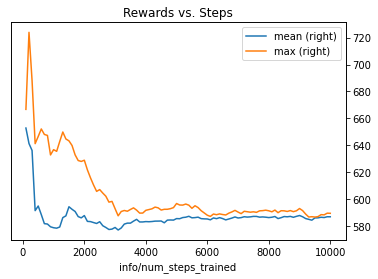

In [23]:
rewards.plot(y=["mean", "max"], secondary_y=True, title="Rewards vs. Steps");

The rewards bounce around at first, then appear to stabilize after 5000 steps, with slow improvement afterwards.

In [24]:
regrets = df_ts \
    .groupby("info/num_steps_trained")["info/learner/default_policy/cumulative_regret"] \
    .aggregate(["mean", "max", "min", "std"])

regrets

,mean,max,min,std
info/num_steps_trained,,,,
100,859.666667,890,832,29.091809
200,1685.333333,1921,1527,208.072904
300,2530.666667,2777,2395,213.696826
400,3456.000000,3654,3219,220.106792
500,4294.666667,4468,3961,289.036907
...,...,...,...,...
9600,82428.666667,82531,82294,121.763432
9700,83310.333333,83382,83175,117.270343
9800,84126.333333,84164,84053,63.516402


<AxesSubplot:title={'center':'Regrets vs. Steps'}, xlabel='info/num_steps_trained'>

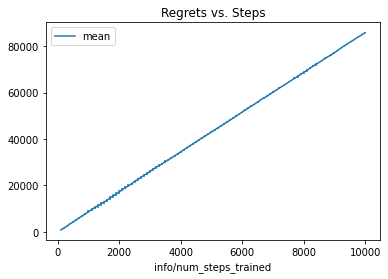

In [25]:
regrets.plot(y="mean", yerr="std", title="Regrets vs. Steps");

## Evaluating the Trained Policy

Overall, how well did the trained policy perform? The results should be better than random, but less than the best case.

In [25]:
print("{:5.2f}% optimized return annualized".format(max(rewards["mean"]) / n_years))

 6.76% optimized return annualized


You should see a approximately 6% annualized return. That's better than the random action baseline of 3.75%, but no where near the best case scenario of 15.18% return. Hence, our regrets continue to grow over time...

Note that investing solely in the S&P stock index which would have produced better than 8% return over that period -- that is, if one could wait 92 years. However, investing one's entire portfolio into stocks can become quite a risky policy in the short-term, so we were exploring how to balance a portfolio given only limited information.

In any case, the contextual bandit performed well considering that it could only use *inflation* for the context of its decisions, and could only take actions once each year.

## Exercise 1

Try using a `LinUCBTrainer`-based trainer.

How does the annualized return compare?

## Exercise 2

Inflation rates tend to get reported months after they've occurred. To be more accurate with using this dataset, offset the *inflation* observation one step (1 year) ahead.

How does the annualized return compare?

---

## Extra - Restoring from a Checkpoint

In the previous lesson, [05 Thompson Sampling](05-Thompson-Sampling.ipynb), we showed how to restore a trainer from a checkpoint, but almost "in passing". Let's use this feature again, this time with our custom trainer class `MarketLinTSTrainer`.

In [ ]:
trial = analysis.trials[0]
path = trial.checkpoint.value
print(f'checkpoint_path: {path}')

In [ ]:
trainer = MarketLinTSTrainer(market_config)  # create instance and then restore from checkpoint
trainer.restore(path)

Access the model, to review the distribution of arm weights

In [ ]:
model = trainer.get_policy().model
means = [model.arms[i].theta.numpy() for i in range(3)]
covs = [model.arms[i].covariance.numpy() for i in range(3)]
means, covs, model.arms[0].theta.numpy()

A final note: using checkpoints will change how the training performs in this notebook, if you rerun it. So be sure to start from scratch when doing experiments here, if that's what you intend!

In [26]:
ray.shutdown()